In [10]:
import pandas as pd

# ----------------------------
# LOAD & BASIC CLEANUP
# ----------------------------
df = pd.read_csv("../data/modified/final_dataset.csv")

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# 🔹 Drop first 10 "calibration" days BEFORE feature engineering
df = df.iloc[10:].reset_index(drop=True)

# ----------------------------
# HELPER: convert mixed column -> 0/1 flag
# works for 0/1, True/False, "True"/"False"
# ----------------------------
def to_flag(series):
    return (
        series.astype(str)
              .str.strip()
              .str.lower()
              .map({'true': 1, 'false': 0, '1': 1, '0': 0})
              .fillna(0)
              .astype(int)
    )

# ----------------------------
# CREATE STANDARD FLAGS
# ----------------------------

# these should already be booleans
df['alcohol_flag']  = df['had_alcohol'].astype(int)
df['caffeine_flag'] = df['had_caffeine'].astype(int)

# these may be 0/1 or "False"/"True"
df['long_task_flag'] = to_flag(df['has_long_tasks'])
df['exam_flag']      = to_flag(df['has_exam'])

# (Optional sanity check)
print(df[['date', 'had_alcohol', 'alcohol_flag',
          'had_caffeine', 'caffeine_flag',
          'has_long_tasks', 'long_task_flag',
          'has_exam', 'exam_flag']].head(10))


        date  had_alcohol  alcohol_flag  had_caffeine  caffeine_flag  \
0 2025-03-07        False             0         False              0   
1 2025-03-08         True             1         False              0   
2 2025-03-08         True             1         False              0   
3 2025-03-09         True             1          True              1   
4 2025-03-10        False             0         False              0   
5 2025-03-11        False             0          True              1   
6 2025-03-11        False             0          True              1   
7 2025-03-11        False             0          True              1   
8 2025-03-11        False             0          True              1   
9 2025-03-11        False             0          True              1   

  has_long_tasks  long_task_flag has_exam  exam_flag  
0          False               0    False          0  
1          False               0    False          0  
2          False               0    False 

In [13]:

short_window = 7    # "week before"
long_window  = 30   # "month before"

metrics = [
    'sleep_hours',
    'sleep_performance_pct',
    'recovery_score_pct',
    'skin_temp_c',
    'day_strain',
    'total_busy_minutes'
]

# 7-day and 30-day averages + "trend" (today vs avg)
for col in metrics:
    df[f'{col}_7d_avg']   = df[col].rolling(short_window, min_periods=3).mean()
    df[f'{col}_7d_trend'] = df[col] - df[f'{col}_7d_avg']

    df[f'{col}_30d_avg']   = df[col].rolling(long_window, min_periods=7).mean()
    df[f'{col}_30d_trend'] = df[col] - df[f'{col}_30d_avg']

# Rolling counts for events (how many days in last week / month)
df['alcohol_7d_count']   = df['alcohol_flag'].rolling(short_window, min_periods=1).sum()
df['caffeine_7d_count']  = df['caffeine_flag'].rolling(short_window, min_periods=1).sum()
df['long_task_7d_count'] = df['long_task_flag'].rolling(short_window, min_periods=1).sum()
df['exam_7d_count']      = df['exam_flag'].rolling(short_window, min_periods=1).sum()

df['alcohol_30d_count']   = df['alcohol_flag'].rolling(long_window, min_periods=1).sum()
df['caffeine_30d_count']  = df['caffeine_flag'].rolling(long_window, min_periods=1).sum()
df['long_task_30d_count'] = df['long_task_flag'].rolling(long_window, min_periods=1).sum()
df['exam_30d_count']      = df['exam_flag'].rolling(long_window, min_periods=1).sum()

# Preview
print(df[['date',
          'recovery_score_pct', 'recovery_score_pct_7d_avg',
          'recovery_score_pct_30d_avg',
          'alcohol_flag', 'alcohol_7d_count', 'alcohol_30d_count']].head(15))


         date  recovery_score_pct  recovery_score_pct_7d_avg  \
0  2025-03-07                66.0                        NaN   
1  2025-03-08                 6.0                        NaN   
2  2025-03-08                 6.0                  26.000000   
3  2025-03-09                77.0                  38.750000   
4  2025-03-10                98.0                  50.600000   
5  2025-03-11                12.0                  44.166667   
6  2025-03-11                12.0                  39.571429   
7  2025-03-11                12.0                  31.857143   
8  2025-03-11                12.0                  32.714286   
9  2025-03-11                15.0                  34.000000   
10 2025-03-11                15.0                  25.142857   
11 2025-03-11                15.0                  13.285714   
12 2025-03-11                15.0                  13.714286   
13 2025-03-13                28.0                  16.000000   
14 2025-03-14                66.0       

In [14]:
# ----------------------------
# DEFINE DATA-DRIVEN THRESHOLDS FOR "BAD" DAYS
# ----------------------------
recov_valid = df['recovery_score_pct'].dropna()
sleep_valid = df['sleep_performance_pct'].dropna()
temp_valid  = df['skin_temp_c'].dropna()

low_recovery_threshold = recov_valid.quantile(0.3)   # worst 30% recovery
bad_sleep_threshold    = sleep_valid.quantile(0.3)   # worst 30% sleep perf
high_temp_threshold    = temp_valid.quantile(0.7)    # top 30% hottest days

print("Low recovery threshold:", low_recovery_threshold)
print("Bad sleep threshold   :", bad_sleep_threshold)
print("High temp threshold   :", high_temp_threshold)

# Day-level labels
df['low_recovery']   = df['recovery_score_pct'] < low_recovery_threshold
df['bad_sleep']      = df['sleep_performance_pct'] < bad_sleep_threshold
df['high_skin_temp'] = df['skin_temp_c'] > high_temp_threshold

# "Tomorrow is bad" labels (so we can look at the week/month BEFORE)
df['low_recovery_tomorrow'] = df['low_recovery'].shift(-1)
df['bad_sleep_tomorrow']    = df['bad_sleep'].shift(-1)
df['high_temp_tomorrow']    = df['high_skin_temp'].shift(-1)

# ----------------------------
# CONTEXT FEATURES (WEEK / MONTH BEFORE)
# ----------------------------
week_features = [
    'sleep_hours_7d_avg',
    'sleep_performance_pct_7d_avg',
    'recovery_score_pct_7d_avg',
    'skin_temp_c_7d_avg',
    'day_strain_7d_avg',
    'total_busy_minutes_7d_avg',
    'alcohol_7d_count',
    'caffeine_7d_count',
    'long_task_7d_count',
    'exam_7d_count'
]

month_features = [
    'sleep_hours_30d_avg',
    'sleep_performance_pct_30d_avg',
    'recovery_score_pct_30d_avg',
    'skin_temp_c_30d_avg',
    'day_strain_30d_avg',
    'total_busy_minutes_30d_avg',
    'alcohol_30d_count',
    'caffeine_30d_count',
    'long_task_30d_count',
    'exam_30d_count'
]

def compare_context(label_col, label_name):
    print(f"\n==== {label_name.upper()} — WEEK BEFORE (7d) ====")
    valid_week = df.dropna(subset=week_features + [label_col])
    bad_week  = valid_week[valid_week[label_col] == True]
    good_week = valid_week[valid_week[label_col] == False]

    week_cmp = pd.concat({
        'bad_next_day' : bad_week[week_features].mean(),
        'good_next_day': good_week[week_features].mean()
    }, axis=1)
    week_cmp['difference'] = week_cmp['bad_next_day'] - week_cmp['good_next_day']
    print(week_cmp.round(2))

    print(f"\n==== {label_name.upper()} — MONTH BEFORE (30d) ====")
    valid_month = df.dropna(subset=month_features + [label_col])
    bad_month  = valid_month[valid_month[label_col] == True]
    good_month = valid_month[valid_month[label_col] == False]

    month_cmp = pd.concat({
        'bad_next_day' : bad_month[month_features].mean(),
        'good_next_day': good_month[month_features].mean()
    }, axis=1)
    month_cmp['difference'] = month_cmp['bad_next_day'] - month_cmp['good_next_day']
    print(month_cmp.round(2))

    return week_cmp, month_cmp

# ----------------------------
# RUN: see what the week/month before bad days looks like
# ----------------------------
week_low_recov, month_low_recov   = compare_context('low_recovery_tomorrow', 'low_recovery')
week_bad_sleep, month_bad_sleep   = compare_context('bad_sleep_tomorrow', 'bad_sleep')
week_high_temp, month_high_temp   = compare_context('high_temp_tomorrow', 'high_temp')


Low recovery threshold: 24.0
Bad sleep threshold   : 44.0
High temp threshold   : 34.8

==== LOW_RECOVERY — WEEK BEFORE (7d) ====
                              bad_next_day  good_next_day  difference
sleep_hours_7d_avg                    5.47           6.66       -1.19
sleep_performance_pct_7d_avg         55.59          67.63      -12.04
recovery_score_pct_7d_avg            38.73          53.54      -14.82
skin_temp_c_7d_avg                   34.70          34.65        0.06
day_strain_7d_avg                    12.18           9.96        2.22
total_busy_minutes_7d_avg            79.26         140.72      -61.46
alcohol_7d_count                      2.52           1.27        1.26
caffeine_7d_count                     1.30           0.70        0.60
long_task_7d_count                    0.10           0.63       -0.53
exam_7d_count                         0.08           0.57       -0.50

==== LOW_RECOVERY — MONTH BEFORE (30d) ====
                               bad_next_day  good_next_

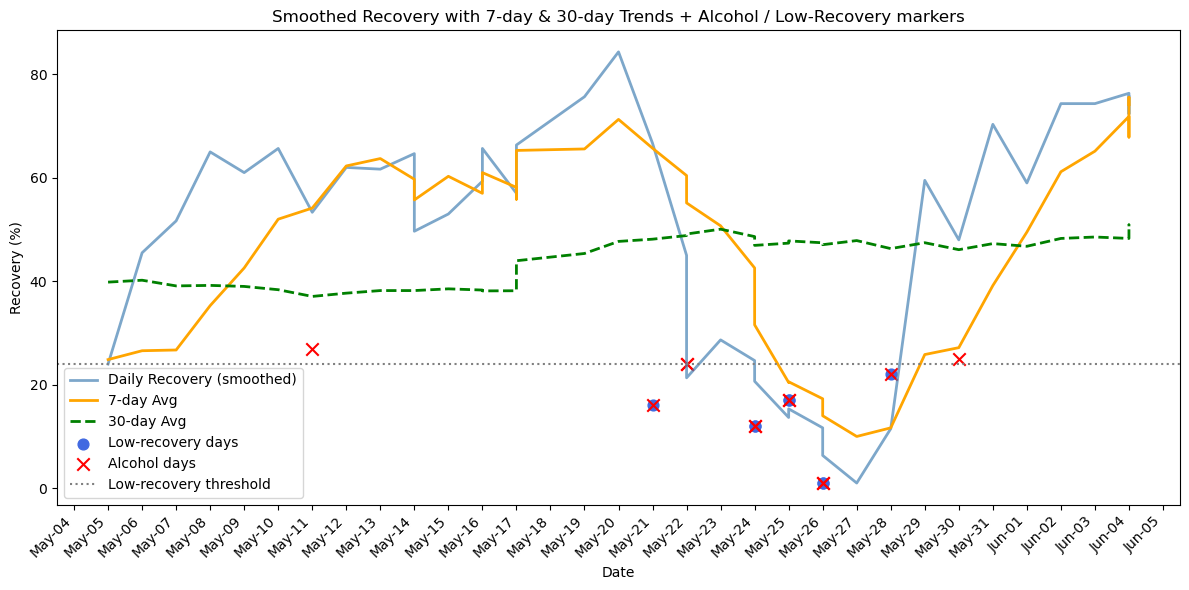

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Prepare recent window
recent = df[(df['date'] >= '2025-05-05') & (df['date'] <= '2025-06-05')].copy()

recent['recovery_smoothed'] = recent['recovery_score_pct'].rolling(window=3, min_periods=1).mean()

# Create plot
plt.figure(figsize=(12,6))

# Lines
plt.plot(recent['date'], recent['recovery_smoothed'],
         label='Daily Recovery (smoothed)', color='steelblue', linewidth=2, alpha=0.7)
plt.plot(recent['date'], recent['recovery_score_pct_7d_avg'],
         label='7-day Avg', color='orange', linewidth=2)
plt.plot(recent['date'], recent['recovery_score_pct_30d_avg'],
         label='30-day Avg', color='green', linestyle='--', linewidth=2)

# Markers
low_rec_mask = recent['low_recovery']
plt.scatter(recent.loc[low_rec_mask, 'date'],
            recent.loc[low_rec_mask, 'recovery_score_pct'],
            color='royalblue', marker='o', s=60, label='Low-recovery days')

plt.scatter(recent.loc[recent['alcohol_flag']==1, 'date'],
            recent.loc[recent['alcohol_flag']==1, 'recovery_score_pct'],
            color='red', marker='x', s=80, label='Alcohol days')

# Threshold line
plt.axhline(df['recovery_score_pct'].quantile(0.3),
            color='gray', linestyle=':', label='Low-recovery threshold')

# --------------------------
# 🗓️ X-axis formatting
# --------------------------
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))   # show Month-Day
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))     # tick every 2 days (adjust as you like)
plt.xticks(rotation=45, ha='right')

# Labels & layout
plt.title("Smoothed Recovery with 7-day & 30-day Trends + Alcohol / Low-Recovery markers")
plt.xlabel("Date")
plt.ylabel("Recovery (%)")
plt.legend()
plt.tight_layout()
plt.show()


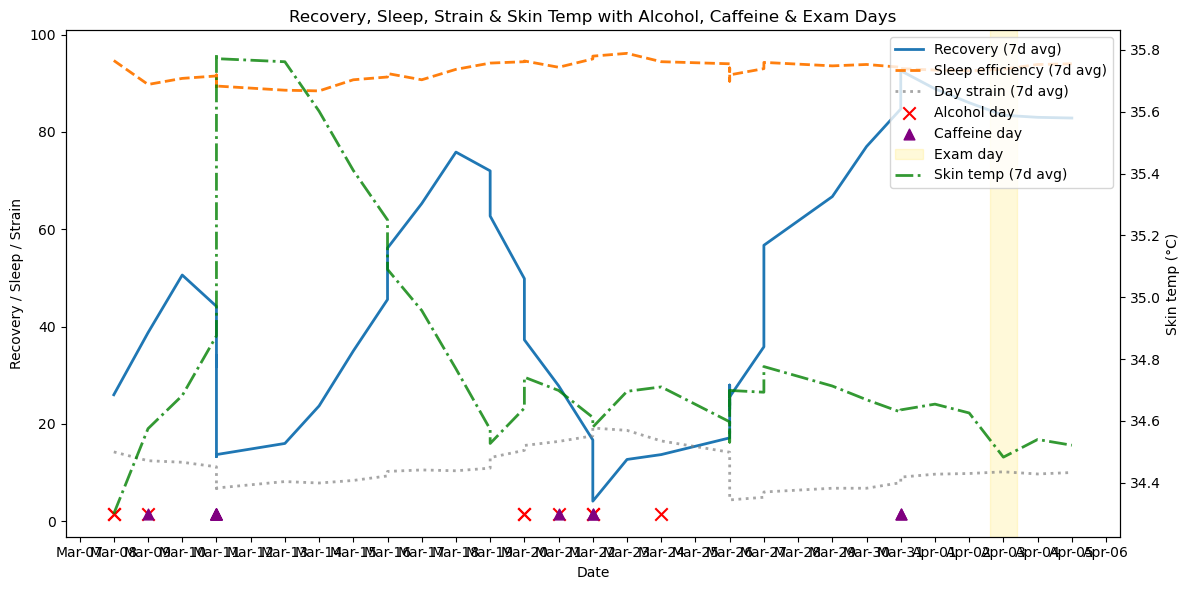

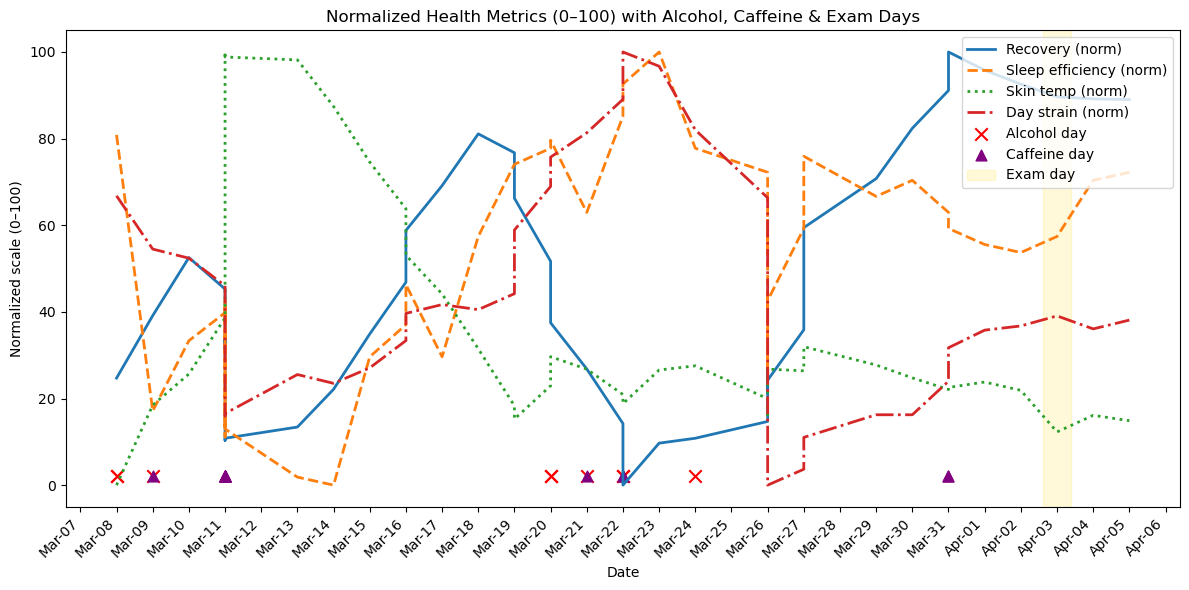


Correlation with 7d Recovery:
recovery_score_pct_7d_avg    1.00
sleep_eff_7d                 0.18
skin_temp_7d                -0.34
strain_7d                   -0.18
alcohol_flag                -0.30
caffeine_flag               -0.20
Name: recovery_score_pct_7d_avg, dtype: float64


In [26]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# ============================
# 1) CHOOSE DATE RANGE
# ============================
start_date = '2025-03-05'
end_date   = '2025-04-05'

recent = df[(df['date'] >= start_date) & (df['date'] <= end_date)].copy()

# 7d smoothing / averages
recent['recovery_7d']   = recent['recovery_score_pct_7d_avg']
recent['sleep_eff_7d']  = recent['sleep_efficiency_pct'].rolling(7, min_periods=3).mean()
recent['skin_temp_7d']  = recent['skin_temp_c_7d_avg']
recent['strain_7d']     = recent['day_strain_7d_avg']

# ============================
# 2) MAIN MULTI-METRIC PLOT
# ============================
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# ---- Left axis: Recovery, Sleep, Strain ----
ax1.plot(recent['date'], recent['recovery_7d'],
         label='Recovery (7d avg)', linewidth=2)
ax1.plot(recent['date'], recent['sleep_eff_7d'],
         label='Sleep efficiency (7d avg)', linewidth=2, linestyle='--')
ax1.plot(recent['date'], recent['strain_7d'],
         label='Day strain (7d avg)', linewidth=2, linestyle=':', alpha=0.7, color='gray')

ax1.set_xlabel("Date")
ax1.set_ylabel("Recovery / Sleep / Strain")

# ---- Right axis: Skin Temp ----
ax2.plot(recent['date'], recent['skin_temp_7d'],
         label='Skin temp (7d avg)', linewidth=2, linestyle='-.', alpha=0.8, color='green')
ax2.set_ylabel("Skin temp (°C)")

# ---- Alcohol & caffeine markers (bottom markers) ----
alcohol_days  = recent[recent['alcohol_flag'] == 1]['date']
caffeine_days = recent[recent['caffeine_flag'] == 1]['date']

ymin, ymax = ax1.get_ylim()
marker_y = ymin + 0.02 * (ymax - ymin)  # just above the bottom

ax1.scatter(alcohol_days, [marker_y] * len(alcohol_days),
            marker='x', s=80, color='red', label='Alcohol day')
ax1.scatter(caffeine_days, [marker_y] * len(caffeine_days),
            marker='^', s=60, color='purple', label='Caffeine day')

# ---- Shade exam periods using exam_flag ----
exam_days = recent[recent['exam_flag'] == 1]['date']
for d in exam_days:
    ax1.axvspan(d - pd.Timedelta(days=0.4),
                d + pd.Timedelta(days=0.4),
                color='gold', alpha=0.15, label='Exam day')

# Avoid duplicate legend entry for multiple exam spans
handles, labels = ax1.get_legend_handles_labels()
seen = set()
unique_handles, unique_labels = [], []
for h, l in zip(handles, labels):
    if l not in seen:
        unique_handles.append(h)
        unique_labels.append(l)
        seen.add(l)

# ---- X-axis formatting ----
ax = ax1
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))  # Month-Day
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))    # every day
plt.xticks(rotation=45, ha='right')

# ---- Legend & title ----
lines_1, labels_1 = unique_handles, unique_labels
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title("Recovery, Sleep, Strain & Skin Temp with Alcohol, Caffeine & Exam Days")
plt.tight_layout()
plt.show()

# ============================
# 3) NORMALIZED VERSION (0–100 SCALE)
# ============================
def normalize(series):
    s = series.dropna()
    if s.empty or s.max() == s.min():
        return series * 0  # avoid divide-by-zero
    return (series - s.min()) / (s.max() - s.min()) * 100

recent['norm_recovery'] = normalize(recent['recovery_7d'])
recent['norm_sleep']    = normalize(recent['sleep_eff_7d'])
recent['norm_temp']     = normalize(recent['skin_temp_7d'])
recent['norm_strain']   = normalize(recent['strain_7d'])

plt.figure(figsize=(12, 6))
plt.plot(recent['date'], recent['norm_recovery'], label='Recovery (norm)', linewidth=2)
plt.plot(recent['date'], recent['norm_sleep'],    label='Sleep efficiency (norm)', linewidth=2, linestyle='--')
plt.plot(recent['date'], recent['norm_temp'],     label='Skin temp (norm)', linewidth=2, linestyle=':')
plt.plot(recent['date'], recent['norm_strain'],   label='Day strain (norm)', linewidth=2, linestyle='-.')

# Re-use event markers
ymin, ymax = 0, 100
marker_y = ymin + 2
plt.scatter(alcohol_days, [marker_y] * len(alcohol_days),
            marker='x', s=80, color='red', label='Alcohol day')
plt.scatter(caffeine_days, [marker_y] * len(caffeine_days),
            marker='^', s=60, color='purple', label='Caffeine day')

for d in exam_days:
    plt.axvspan(d - pd.Timedelta(days=0.4),
                d + pd.Timedelta(days=0.4),
                color='gold', alpha=0.15, label='Exam day')

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=45, ha='right')

handles, labels = ax.get_legend_handles_labels()
seen = set()
uh, ul = [], []
for h, l in zip(handles, labels):
    if l not in seen:
        uh.append(h); ul.append(l); seen.add(l)
plt.legend(uh, ul, loc='upper right')

plt.title("Normalized Health Metrics (0–100) with Alcohol, Caffeine & Exam Days")
plt.xlabel("Date")
plt.ylabel("Normalized scale (0–100)")
plt.tight_layout()
plt.show()

# ============================
# 4) CORRELATIONS (for your insights text)
# ============================
corr_cols = [
    'recovery_score_pct_7d_avg',
    'sleep_eff_7d',
    'skin_temp_7d',
    'strain_7d',
    'alcohol_flag',
    'caffeine_flag'
]

corrs = recent[corr_cols].corr()['recovery_score_pct_7d_avg'].round(2)
print("\nCorrelation with 7d Recovery:")
print(corrs)
